In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, ttest_ind, ttest_rel, wilcoxon, beta, chi2
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
def create_data(control, treatement, control_cr, treatement_cr, seed=7):
    np.random.seed(seed)
    conv_control = np.random.binomial(n=control, p=control_cr)
    conv_treatement = np.random.binomial(n=treatement, p=treatement_cr)
    data = pd.DataFrame({'Group': ['visitors_control', 'visitors_treatement'], 'Visitors': [control, treatement], 'Conversions': [conv_control, conv_treatement]})
    return data

#generating synthetic data
data = create_data(control=1000, treatement=1000, control_cr=0.10, treatement_cr=0.12)

In [ ]:
def frequentist_tests(data, alpha=0.05):
    control = data.loc[data['Group'] == 'visitors_control', 'Visitors'].values[0]
    treatement = data.loc[data['Group'] == 'visitors_treatement', 'Visitors'].values[0]
    conv_control = data.loc[data['Group'] == 'visitors_control', 'Conversions'].values[0]
    conv_treatement = data.loc[data['Group'] == 'visitors_treatement', 'Conversions'].values[0]

    #2-proportion z-test
    count = np.array([conv_control, conv_treatement])
    nobs = np.array([control, treatement])
    z_stat, p_value_z = proportions_ztest(count, nobs)
    ci_visitors_control = proportion_confint(conv_control, control, alpha=alpha)
    ci_visitors_treatement = proportion_confint(conv_treatement, treatement, alpha=alpha)

    #chisquared test
    contingency_table = np.array([[conv_control, control - conv_control], [conv_treatement, treatement - conv_treatement]])
    chi2_val, p_val, dof, expected = chi2_contingency(contingency_table, correction=False)
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    alpha = 1.0 - prob

    #fisher's test
    _, p_value_fisher = fisher_exact(contingency_table)

    results = {'z_test': {'z_stat': z_stat, 'p_value': p_value_z, 'ci_visitors_control': ci_visitors_control, 'ci_visitors_treatement': ci_visitors_treatement, 'significant': p_value_z < alpha},
        'chi2_test': {'chi2_stat': chi2_val, 'p_value': p_val, 'critical value': critical, 'dof': dof, 'significant': p_val <= alpha},
        'fisher_test': {'p_value': p_value_fisher, 'significant': p_value_fisher < alpha}}
    return results


In [ ]:
def bayesian_test(data, n_samples=10000):
    control = data.loc[data['Group'] == 'visitors_control', 'Visitors'].values[0]
    treatement = data.loc[data['Group'] == 'visitors_treatement', 'Visitors'].values[0]
    conv_control = data.loc[data['Group'] == 'visitors_control', 'Conversions'].values[0]
    conv_treatement = data.loc[data['Group'] == 'visitors_treatement', 'Conversions'].values[0]

    alpha_prior, beta_prior = 1, 1  #uniform prior

    posterior_visitors_control = stats.beta(alpha_prior + conv_control, beta_prior + control - conv_control)
    posterior_visitors_treatement = stats.beta(alpha_prior + conv_treatement, beta_prior + treatement - conv_treatement)

    samples_visitors_control = posterior_visitors_control.rvs(n_samples)
    samples_visitors_treatement = posterior_visitors_treatement.rvs(n_samples)
    prob_visitors_treatement_better_than_visitors_control = np.mean(samples_visitors_treatement > samples_visitors_control)
    ci_visitors_control = np.percentile(samples_visitors_control, [2.5, 97.5])
    ci_visitors_treatement = np.percentile(samples_visitors_treatement, [2.5, 97.5])

    return {
        'posterior_visitors_control': posterior_visitors_control, 'posterior_visitors_treatement': posterior_visitors_treatement, 'prob_visitors_treatement_better_than_visitors_control': prob_visitors_treatement_better_than_visitors_control, 'ci_visitors_control': ci_visitors_control, 'ci_visitors_treatement': ci_visitors_treatement}

def plot_bayesian_posteriors(bayesian_results):
    x = np.linspace(0, 0.2, 1000)
    posterior_visitors_control = bayesian_results['posterior_visitors_control']
    posterior_visitors_treatement = bayesian_results['posterior_visitors_treatement']

    plt.figure(figsize=(4, 3))
    plt.plot(x, posterior_visitors_control.pdf(x), label='Posterior visitors_control (Modal Form)')
    plt.plot(x, posterior_visitors_treatement.pdf(x), label='Posterior visitors_treatement (Embedded Form)')
    plt.legend()
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.title('Posterior Distributions')
    plt.show()

In [ ]:
frequentist_results = frequentist_tests(data)
print("Frequentist Results:")
for test, result in frequentist_results.items():
    print(f"{test}:")
    for key, value in result.items():
        print(f"  {key}: {value}")


Frequentist Results:

z_test:
  z_stat: -2.334150276930905
  p_value: 0.01958785446157362
  ci_visitors_control: (0.07135172417137982, 0.10664827582862017)
  ci_visitors_treatement: (0.1007867934579838, 0.1412132065420162)
  significant: True

chi2_test:
  chi2_stat: 5.448257515296621
  p_value: 0.01958785446157363
  critical value: 3.841458820694124
  dof: 1
  significant: True

fisher_test:
  p_value: 0.023562508213241108
  significant: True


visitors_treatement Bayesian Results:
  prob_visitors_treatement_better_than_visitors_control: 0.9905

  ci_visitors_control: [0.07262493 0.10808348]

  ci_visitors_treatement: [0.1019244  0.14246893]



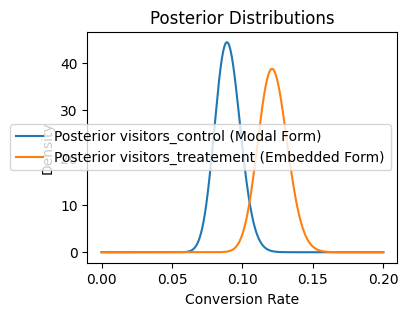

In [ ]:
bayesian_results = bayesian_test(data)
print("visitors_treatement Bayesian Results:")
for key, value in bayesian_results.items():
    if key in ['posterior_visitors_control', 'posterior_visitors_treatement']:
        continue
    print(f"  {key}: {value}")
    print(f"")


plot_bayesian_posteriors(bayesian_results)